---
<center> <h1> Seoul Bike Rental Prediction - AI-Pro - ITI </h1> </center>
<center> <h3> Predict the demand for rental bikes. </h3> </center>


We are provided hourly rental data along with weather data. For this competition, the training set is comprised of the first 20 days of each month, while the test set is the 21th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

---
#### Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
sns.set_style(style='white')
from matplotlib.pyplot import figure

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import sklearn.gaussian_process as gp
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor

from sklearn.preprocessing import FunctionTransformer, PowerTransformer

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.columns = ['ID', 'Date', 'y', 'Hour', 'Temperature', 'Humidity','Wind speed', 'Visibility','Dew point temperature',
                'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning Day']

- All Columns (Features)

In [5]:
data.columns.array

<PandasArray>
[                   'ID',                  'Date',                     'y',
                  'Hour',           'Temperature',              'Humidity',
            'Wind speed',            'Visibility', 'Dew point temperature',
       'Solar Radiation',              'Rainfall',              'Snowfall',
               'Seasons',               'Holiday',       'Functioning Day']
Length: 15, dtype: object

In [6]:
data.head()

,ID,Date,y,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [7]:
data.shape

(5760, 15)

- Shape of Data is (5760, 15)

----

#### Data Exploration

In [8]:
data.dtypes

ID                         int64
Date                      object
y                          int64
Hour                       int64
Temperature              float64
Humidity                   int64
Wind speed               float64
Visibility                 int64
Dew point temperature    float64
Solar Radiation          float64
Rainfall                 float64
Snowfall                 float64
Seasons                   object
Holiday                   object
Functioning Day           object
dtype: object

- Most of the features are Numerical, Except for `Date, Seasons (Spring, Winter, Autumn, Summer), Holiday and Functioning Day`.

In [9]:
data.isna().sum()

ID                       0
Date                     0
y                        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

- All features have no Empty Values.

In [10]:
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")

In [11]:
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

---

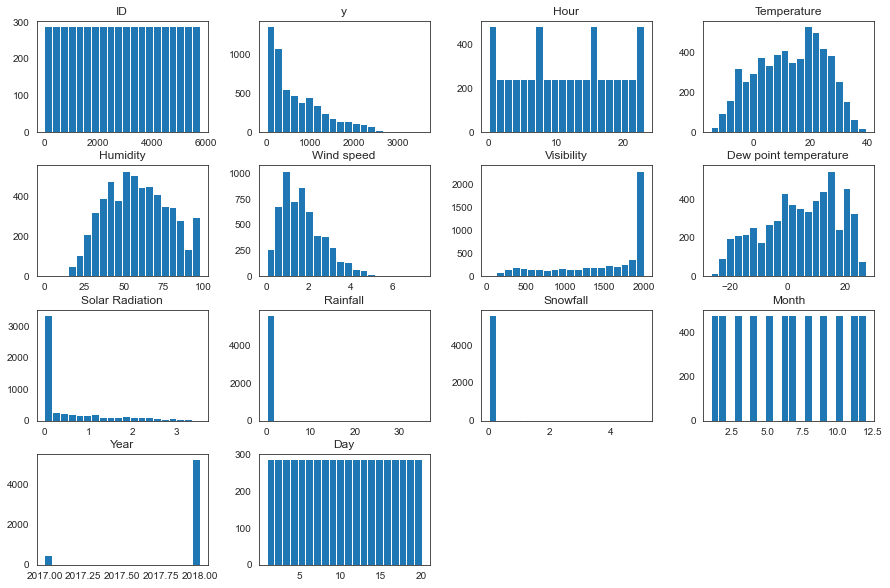

In [12]:
data.hist(figsize=(15, 10), bins=20, grid=False);

---

##### Categorical Data Plotting `Holidays vs Mean of The Target` and `Seasons Against vs Mean of The Target`. 

<AxesSubplot:xlabel='Seasons', ylabel='y'>

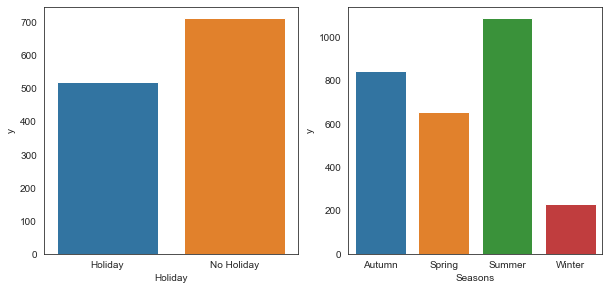

In [13]:
holidays = pd.DataFrame(data.groupby('Holiday').agg({'y':'mean'}))
seasons = pd.DataFrame(data.groupby('Seasons').agg({'y':'mean'}))

figure(figsize=(10, 10))
plt.subplot(2, 2,1)
sns.barplot(x=holidays.index, y = holidays['y'])
plt.subplot(2, 2,2)
sns.barplot(x=seasons.index, y = seasons['y'])

Text(0, 0.5, 'Counts')

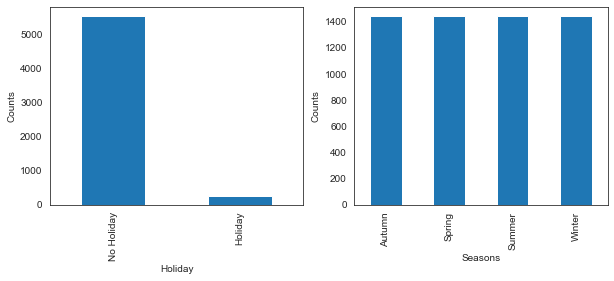

In [14]:
figure(figsize=(10, 8))
plt.subplot(2, 2,3)
data['Holiday'].value_counts().plot(kind='bar')
plt.xlabel('Holiday')
plt.ylabel('Counts')

plt.subplot(2, 2,4)
data['Seasons'].value_counts().plot(kind='bar')
plt.xlabel('Seasons')
plt.ylabel('Counts')

-----

In [15]:
train = data[data["Functioning Day"] == "Yes"]
# train = data.copy()

- When Functioning Day equals `No`, The Number of Bicycle per Hr is 0!

In [16]:
train.describe()

,ID,y,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Month,Year,Day
count,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000,5513.000000
mean,2805.231816,735.002177,11.510793,12.670361,58.223109,1.724197,1475.419010,3.895846,0.570268,0.133884,0.048377,6.386722,2017.912933,10.566661
std,1645.545408,652.243422,6.920207,12.103558,19.958064,1.045593,585.452083,13.233993,0.868271,1.063481,0.330750,3.450866,0.281959,5.770869
min,0.000000,2.000000,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000,1.000000,2017.000000,1.000000
25%,1378.000000,215.000000,6.000000,2.800000,43.000000,1.000000,1034.000000,-6.100000,0.000000,0.000000,0.000000,3.000000,2018.000000,6.000000
50%,2804.000000,532.000000,12.000000,13.500000,57.000000,1.500000,1733.000000,4.700000,0.010000,0.000000,0.000000,6.000000,2018.000000,11.000000
75%,4182.000000,1094.000000,18.000000,22.500000,73.000000,2.300000,2000.000000,15.000000,0.930000,0.000000,0.000000,9.000000,2018.000000,16.000000
max,5759.000000,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000,12.000000,2018.000000,20.000000


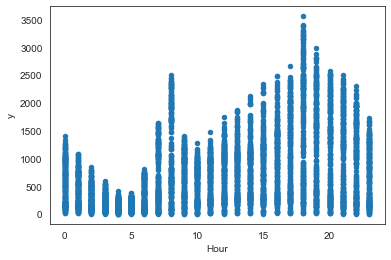

In [17]:
train.plot(y='y', x='Hour', kind='scatter');

In [18]:
train.skew()

ID                        0.048409
y                         1.138949
Hour                     -0.001935
Temperature              -0.144444
Humidity                  0.127140
Wind speed                0.945015
Visibility               -0.814488
Dew point temperature    -0.285626
Solar Radiation           1.493784
Rainfall                 15.927920
Snowfall                  8.708810
Month                     0.053316
Year                     -2.930095
Day                      -0.025623
dtype: float64

---

##### Some Feature Engineering:
- One Hot Encoding for `Holiday` and Ordinal Encoding for `Seasons` 

In [19]:
train["Day"] = pd.factorize(train['Day'])[0].reshape(-1, 1)

<ipython-input-19-93a2a0f1a517>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Day"] = pd.factorize(train['Day'])[0].reshape(-1, 1)


In [20]:
c = []
for i in train['Hour']:
    if i>= 6 and i<= 18 :
        c.append("Day")
    else:
        c.append("Night")
        
train['DayorNight'] = c
train['DayorNight'] = pd.factorize(train['DayorNight'])[0].reshape(-1, 1)
train.head()

<ipython-input-20-b692b3ea9a85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['DayorNight'] = c
<ipython-input-20-b692b3ea9a85>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['DayorNight'] = pd.factorize(train['DayorNight'])[0].reshape(-1, 1)


,ID,Date,y,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Month,Year,Day,DayorNight
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,0,0
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,0,0
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,0,0
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,0,0
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,0,0


In [21]:
train.DayorNight.value_counts()

1    2989
0    2524
Name: DayorNight, dtype: int64

In [22]:
seasons_map = {"Winter": 0, "Autumn": 1, "Spring": 2, "Summer": 3}

In [23]:
train = pd.get_dummies(train, columns=['Seasons'], prefix=['Seasons'])

In [24]:
train["Holiday"] = np.where(train['Holiday'] == 'Holiday', 1, 0)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5513 entries, 0 to 5759
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     5513 non-null   int64         
 1   Date                   5513 non-null   datetime64[ns]
 2   y                      5513 non-null   int64         
 3   Hour                   5513 non-null   int64         
 4   Temperature            5513 non-null   float64       
 5   Humidity               5513 non-null   int64         
 6   Wind speed             5513 non-null   float64       
 7   Visibility             5513 non-null   int64         
 8   Dew point temperature  5513 non-null   float64       
 9   Solar Radiation        5513 non-null   float64       
 10  Rainfall               5513 non-null   float64       
 11  Snowfall               5513 non-null   float64       
 12  Holiday                5513 non-null   int32         
 13  Fun

In [26]:
train["Date_tmp"] = train['Date'].dt.to_period('M')

In [27]:
new_feature_df = pd.DataFrame(train.groupby(['Date_tmp', 'Year'])['y'].mean()).sort_values(["Year"])

In [28]:
new_feature_df = pd.DataFrame(new_feature_df['y'].shift(+1))

In [29]:
new_feature_df.reset_index(inplace=True)

In [30]:
new_feature_df.rename(columns={'y':'Prev Month y'}, inplace=True)

In [31]:
new_feature_df.drop(['Year'], axis = 1, inplace =True)

In [32]:
new_feature_df.fillna(225, inplace = True)

In [33]:
new_feature_df

,Date_tmp,Prev Month y
0,2017-12,225.000000
1,2018-01,264.885417
2,2018-02,230.316667
3,2018-03,200.100000
4,2018-04,458.210417
5,2018-05,697.989035
6,2018-06,881.692982
7,2018-07,1310.687500
8,2018-08,1019.414583
9,2018-09,927.014583


In [34]:
train = pd.merge(train, new_feature_df, on='Date_tmp', how='left')

In [35]:
train.DayorNight.value_counts()

1    2989
0    2524
Name: DayorNight, dtype: int64

<Figure size 1440x1440 with 0 Axes>

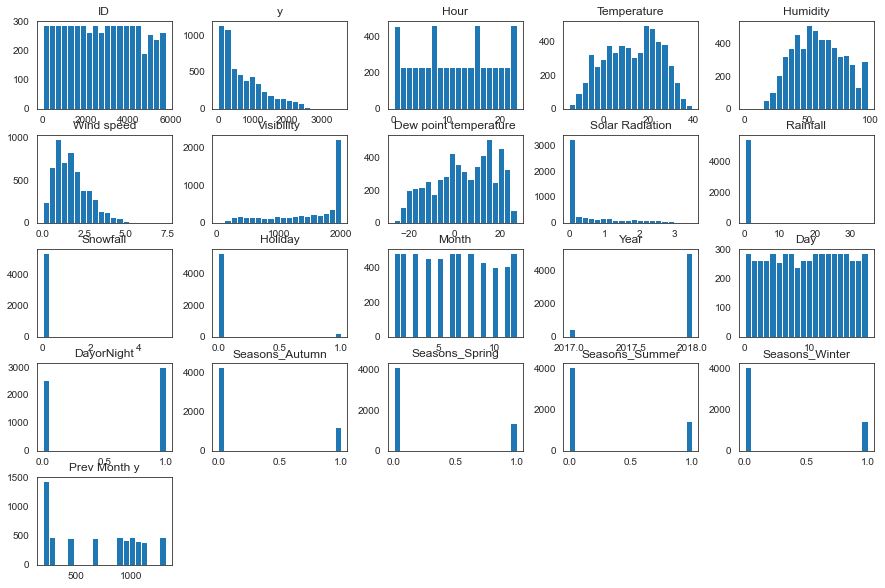

In [36]:
figure(figsize=(20, 20))
train.hist(figsize=(15, 10), bins=20, grid=False);

---

- ##### Checking Correlations using correlation table and Heat-Map

<AxesSubplot:>

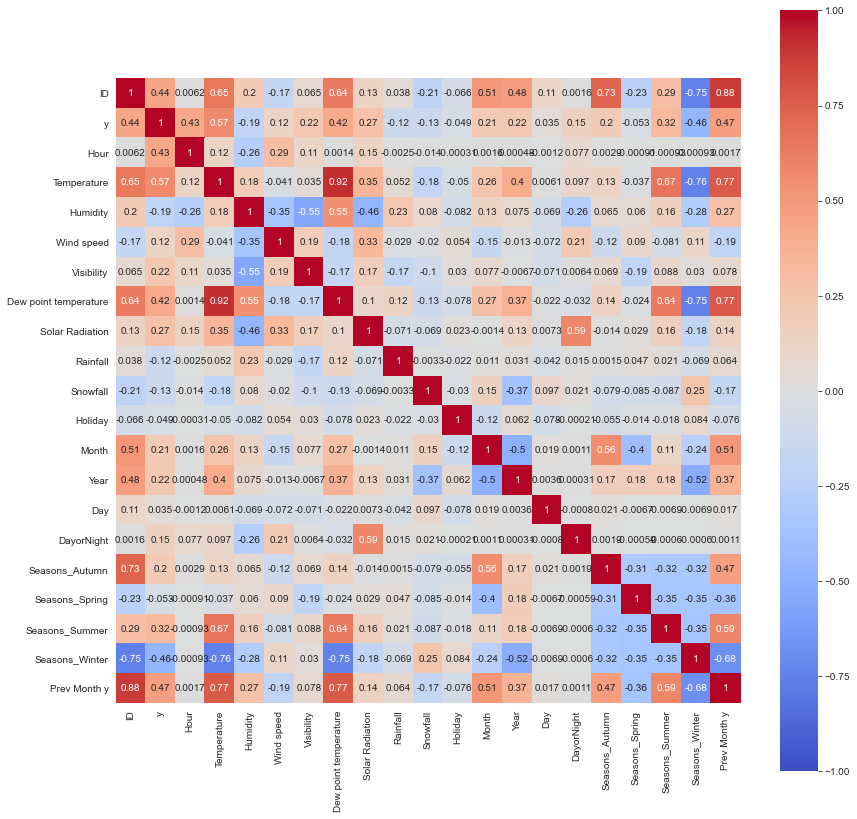

In [37]:
plt.figure(figsize=(14, 14))
sns.heatmap(train.corr("pearson"), vmin=-1, vmax=1, cmap='coolwarm', annot=True, square=True)

We Can see a **notable correlation ratio (Above 2)** between `Y (Count of Bicycles per Hr)` and:
- `Hour`
- `Temperature`
- `Dew point temperature`
- `Solar Radiation`
- `Seasons`
- `Prev Month y`

We need to check some of the Linear model Assumbions: <br>
- **Linearity**: The mean values of the outcome variable for each increment of the predictor(s) lie along a straight line. In other words, there is a linear relationship between predictors and target.

- **No perfect multicollinearity**: There should be no perfect linear relationship between two or more of the predictors. 

- **Normally distributed errors**: the residuals are random, normally distributed with a mean of 0.

- **Homoscedasticity**: At each level of the predictor variable(s), the variance of the residual terms should be constant.


##### No perfect multicollinearity:
To determine co-linearity, we evaluate the correlation of all the independent variables in the dataframe.

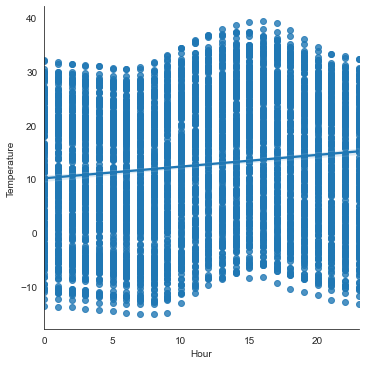

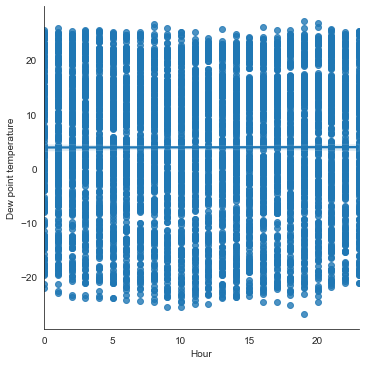

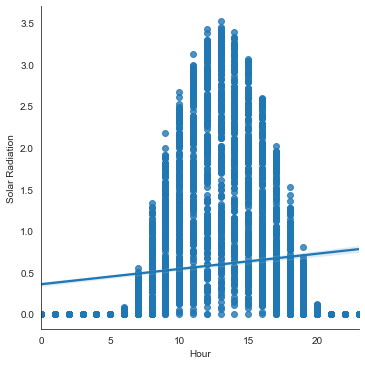

In [38]:
sns.lmplot(x="Hour", y="Temperature", data=train, order=1)
sns.lmplot(x="Hour", y="Dew point temperature", data=train, order=1)
sns.lmplot(x="Hour", y="Solar Radiation", data=train, order=1)

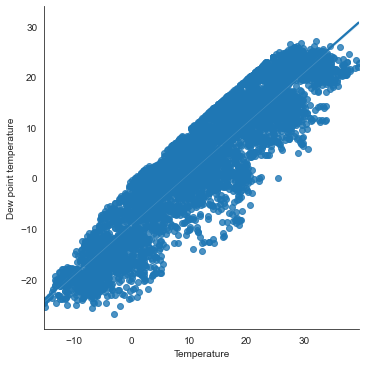

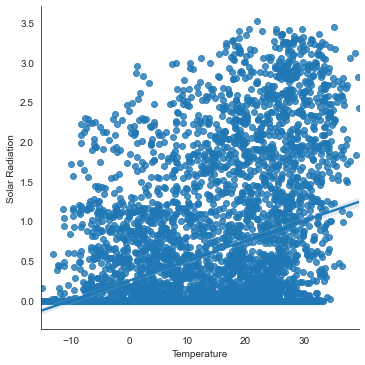

In [39]:
sns.lmplot(x="Temperature", y="Dew point temperature", data=train, order=1)
sns.lmplot(x="Temperature", y="Solar Radiation", data=train, order=1)

- ##### There's a Strong Correlation Between `Temperature` and `Dew point temperature`. And in order to use a Linear Model we have to drop the least correlated with the target!

#### Homoscedasticity

Homoscedasticity implies that at each level of the predictor variable(s), the variance of the residual terms should be constant. So we need to plot the residuals against the variables.

Homoscedasticity, also known as homogeneity of variance, describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables X and the dependent variable Y is the same across all the independent variables.

The way to identify if the variables are homoscedastic, is to make a linear model with all the independent variables involved, calculate the residuals, and plot the residuals vs each one of the independent variables. If the distribution of the residuals is homogeneous across the variable values, then the variables are homoscedastic.


---

- ### Identifing variables distribution.

In [40]:
def diagnostic_plots(df, variable):

    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [41]:
train.Hour.value_counts()

23    230
19    230
8     230
12    230
16    230
20    230
9     230
13    230
17    230
21    230
10    230
14    230
18    230
22    230
7     230
11    230
15    230
6     229
2     229
5     229
1     229
3     229
4     229
0     229
Name: Hour, dtype: int64

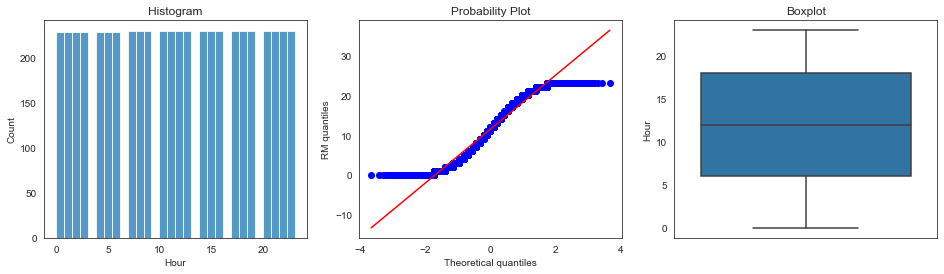

In [42]:
diagnostic_plots(train, 'Hour')

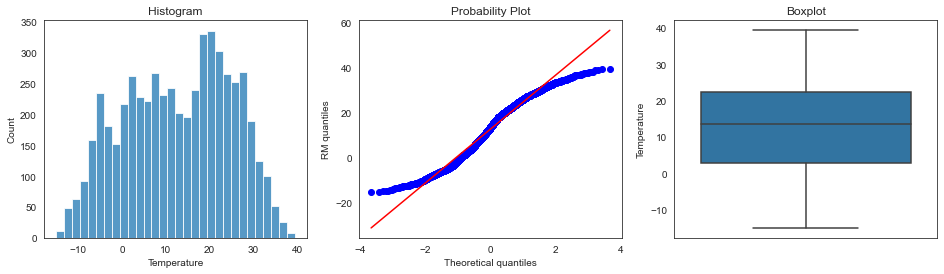

In [43]:
diagnostic_plots(train, 'Temperature')

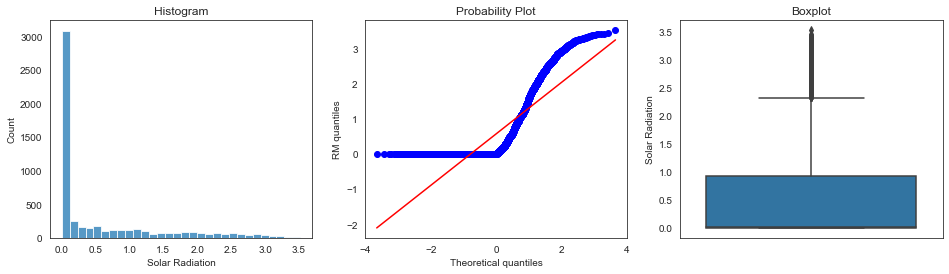

In [44]:
diagnostic_plots(train, 'Solar Radiation')

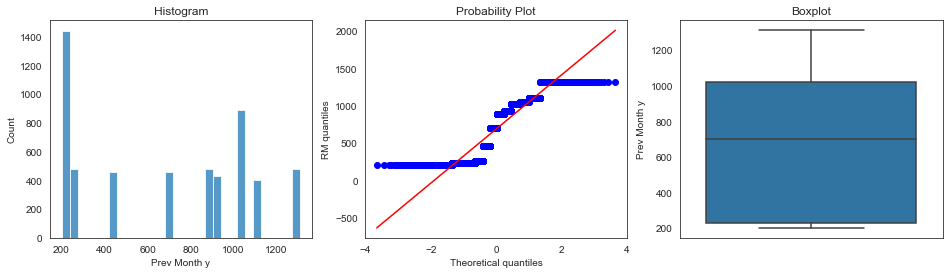

In [45]:
diagnostic_plots(train, 'Prev Month y')

In [46]:
def find_normal_boundaries(df, variable):

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [47]:
def find_skewed_boundaries(df, variable, distance):
    
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [48]:
upper_boundary, lower_boundary = find_skewed_boundaries(train, 'Solar Radiation', 2.5)
upper_boundary, lower_boundary

(3.2550000000000003, -2.325)

- ###### There's a no Normal Formality in the plots of The `Hour`, `Solar Radiation and Also Seasons`. And theses are the reasons we are not going to apply a linear model!

---

### Trying The XGBoost Model

In [49]:
train["y"] = np.log(train["y"])

In [50]:
np.exp(train["y"])

0        254.0
1        204.0
2        173.0
3        107.0
4         78.0
         ...  
5508    1317.0
5509    1078.0
5510    1020.0
5511     922.0
5512     378.0
Name: y, Length: 5513, dtype: float64

In [51]:
train.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature', 'Humidity', 'Wind speed',
       'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall',
       'Snowfall', 'Holiday', 'Functioning Day', 'Month', 'Year', 'Day',
       'DayorNight', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Date_tmp', 'Prev Month y'],
      dtype='object')

In [53]:
!pip install xgboost

In [54]:
import xgboost as xgb

In [55]:
X = train.drop(["ID", "y", "Date", "Functioning Day", "Date_tmp", "Dew point temperature"], axis=1)
y = train["y"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [57]:
n_estimators = [100, 150, 200]

# Maximum depth of trees
max_depth = [6, 8, 10, 20]

# Child weight
min_child_weight= [8, 10, 20]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,'min_child_weight': min_child_weight }

param_dict

{'n_estimators': [100, 150, 200],
 'max_depth': [6, 8, 10, 20],
 'min_child_weight': [8, 10, 20]}

In [58]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.array([np.log(y+1) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1) for y in y_pred]))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [59]:
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 

In [60]:
XGB = xgb.XGBRegressor()

grid = GridSearchCV(estimator = XGB,
                       param_grid = param_dict,
                       cv = 3, verbose=2, scoring = rmsle_scorer)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_depth=6, min_child_weight=8, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, min_child_weight=8, n_estimators=100, total=   0.4s
[CV] max_depth=6, min_child_weight=8, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=6, min_child_weight=8, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_child_weight=8, n_estimators=100 ...............
[CV]  max_depth=6, min_child_weight=8, n_estimators=100, total=   0.2s
[CV] max_depth=6, min_child_weight=8, n_estimators=150 ...............
[CV]  max_depth=6, min_child_weight=8, n_estimators=150, total=   0.3s
[CV] max_depth=6, min_child_weight=8, n_estimators=150 ...............
[CV]  max_depth=6, min_child_weight=8, n_estimators=150, total=   0.3s
[CV] max_depth=6, min_child_weight=8, n_estimators=150 ...............
[CV]  max_depth=6, min_child_weight=8, n_estimators=150, total=   0.3s
[CV] max_depth=6, min_child_weight=8, n_estimators=200 ...............
[CV]  max_depth=6, min_child_weight=8, n_estimators=200, total=   0.4s
[CV] max_depth=6, min_child_weight=8, n_estimators=200 ...............
[CV]  max_depth=6, min_child_weight=8, n_estimators=200, total=   0.4s
[CV] max_depth=6, min_child_weight=8, n_estimators=200 ...............
[CV]  

[CV]  max_depth=10, min_child_weight=8, n_estimators=150, total=   0.6s
[CV] max_depth=10, min_child_weight=8, n_estimators=200 ..............
[CV]  max_depth=10, min_child_weight=8, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_child_weight=8, n_estimators=200 ..............
[CV]  max_depth=10, min_child_weight=8, n_estimators=200, total=   0.8s
[CV] max_depth=10, min_child_weight=8, n_estimators=200 ..............
[CV]  max_depth=10, min_child_weight=8, n_estimators=200, total=   0.7s
[CV] max_depth=10, min_child_weight=10, n_estimators=100 .............
[CV]  max_depth=10, min_child_weight=10, n_estimators=100, total=   0.4s
[CV] max_depth=10, min_child_weight=10, n_estimators=100 .............
[CV]  max_depth=10, min_child_weight=10, n_estimators=100, total=   0.4s
[CV] max_depth=10, min_child_weight=10, n_estimators=100 .............
[CV]  max_depth=10, min_child_weight=10, n_estimators=100, total=   0.4s
[CV] max_depth=10, min_child_weight=10, n_estimators=150 ..........

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   55.5s finished


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [61]:
# param_grid =  {'n_estimators': [50,100,150,300,500,40]}

# kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# best = GridSearchCV(estimator=BaggingRegressor(DecisionTreeRegressor(min_samples_split = 10)), 
#                     param_grid=param_grid, 
#                     scoring=rmsle_scorer, 
#                     cv=5, 
#                     n_jobs=None,verbose=0)

# best.fit(X_train, y_train)

In [62]:
grid.best_score_
# xgb.fit(X_train, y_train)

-0.4008904739063089

In [63]:
grid.best_params_

{'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 200}

In [64]:
optimal_model = grid.best_estimator_
optimal_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
y_pred_train = optimal_model.predict(X_train)   
y_pred_test = optimal_model.predict(X_test)

In [66]:
print('(Train) XGB Regression RMSLE:', rmsle(y_train, y_pred_train, True))

(Train) XGB Regression RMSLE: 0.040662156567967324


In [67]:
print('(Test) XGB Regression RMSLE:', rmsle(y_test, y_pred_test, True))

(Test) XGB Regression RMSLE: 0.4069693075790566


In [68]:
r2_score(y_test, y_pred_test)

0.8760003518922674

In [69]:
r2_score(y_train, y_pred_train)

0.9987525477197735

---


In [70]:
rf_model = RandomForestRegressor()

In [71]:
rf_param_dict = {'random_state':[42], 
                 'n_estimators':[100, 120, 140]}

In [72]:
rf_grid = GridSearchCV(estimator = rf_model,
                                              param_grid = rf_param_dict,
                                              scoring = rmsle_scorer,
                                              cv=5)

In [73]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [100, 120, 140], 'random_state': [42]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [74]:
rf_grid.best_score_

-0.4058892282640344

In [75]:
rf_grid.best_estimator_

RandomForestRegressor(n_estimators=120, random_state=42)

In [76]:
RF_y_pred_train = rf_grid.predict(X_train)
RF_y_pred_test = rf_grid.predict(X_test)

In [77]:
print('RF Regression RMSLE:', rmsle(y_train, RF_y_pred_train, True))

RF Regression RMSLE: 0.14764937381513568


In [78]:
print('RF Regression RMSLE:', rmsle(y_test, RF_y_pred_test, True))

RF Regression RMSLE: 0.45002638518650706


In [79]:
r2_score(y_test, RF_y_pred_test)

0.848520952726702

In [84]:
r2_score(y_train, RF_y_pred_train)

0.9831743881650302

----

### GPR Model

---

### Submission

In [85]:
df_test = pd.read_csv("test.csv")

In [86]:
df_test.columns = ['ID', 'Date', 'Hour', 'Temperature', 'Humidity','Wind speed', 'Visibility','Dew point temperature',
                'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning Day']

In [87]:
df_test['Date'] = pd.to_datetime(df_test['Date'], format="%d/%m/%Y")
df_test['Month'] = df_test['Date'].dt.month
df_test['Year'] = df_test['Date'].dt.year
df_test['Day'] = df_test['Date'].dt.day


In [88]:
c = []
for i in df_test['Hour']:
    if i>= 6 and i<= 18 :
        c.append("Day")
    else:
        c.append("Night")
        
df_test['DayorNight'] = c
df_test['DayorNight'] = pd.factorize(df_test['DayorNight'])[0].reshape(-1, 1)
df_test.head()

,ID,Date,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Month,Year,Day,DayorNight
0,5760,2017-12-21,0,-1.3,90,2.0,259,-2.7,0.0,0.0,2.2,Winter,No Holiday,Yes,12,2017,21,0
1,5761,2017-12-21,1,-1.8,90,1.6,263,-3.2,0.0,0.0,2.2,Winter,No Holiday,Yes,12,2017,21,0
2,5762,2017-12-21,2,-2.2,88,1.4,348,-3.9,0.0,0.0,2.2,Winter,No Holiday,Yes,12,2017,21,0
3,5763,2017-12-21,3,-2.9,89,1.3,288,-4.4,0.0,0.0,2.2,Winter,No Holiday,Yes,12,2017,21,0
4,5764,2017-12-21,4,-3.6,91,1.2,241,-4.8,0.0,0.0,2.2,Winter,No Holiday,Yes,12,2017,21,0


In [89]:
df_test["Day"] = pd.factorize(df_test['Day'])[0].reshape(-1, 1)

In [90]:
df_test = pd.get_dummies(df_test, columns=['Seasons'], prefix=['Seasons'])
df_test["Holiday"] = np.where(df_test['Holiday'] == 'Holiday', 1, 0)

In [91]:
df_test["Date_tmp"] = df_test['Date'].dt.to_period('M')

In [92]:
df_test = pd.merge(df_test, new_feature_df, on='Date_tmp', how='left')

In [93]:
df_test.dtypes

ID                                int64
Date                     datetime64[ns]
Hour                              int64
Temperature                     float64
Humidity                          int64
Wind speed                      float64
Visibility                        int64
Dew point temperature           float64
Solar Radiation                 float64
Rainfall                        float64
Snowfall                        float64
Holiday                           int32
Functioning Day                  object
Month                             int64
Year                              int64
Day                               int64
DayorNight                        int64
Seasons_Autumn                    uint8
Seasons_Spring                    uint8
Seasons_Summer                    uint8
Seasons_Winter                    uint8
Date_tmp                      period[M]
Prev Month y                    float64
dtype: object

In [94]:
df_test.drop(["Date", "Date_tmp", "Functioning Day", "Dew point temperature"], axis=1, inplace=True)

In [95]:
df_test.dtypes

ID                   int64
Hour                 int64
Temperature        float64
Humidity             int64
Wind speed         float64
Visibility           int64
Solar Radiation    float64
Rainfall           float64
Snowfall           float64
Holiday              int32
Month                int64
Year                 int64
Day                  int64
DayorNight           int64
Seasons_Autumn       uint8
Seasons_Spring       uint8
Seasons_Summer       uint8
Seasons_Winter       uint8
Prev Month y       float64
dtype: object

In [96]:
preds = optimal_model.predict(df_test.drop(["ID"], axis=1))

---

In [97]:
df_test['y'] = np.exp(preds)

In [98]:
df_test[["ID", "y"]].to_csv('submission.csv', index=False)

In [99]:
df_test.y.value_counts()

232.999863     1
136.333405     1
202.896591     1
274.623810     1
3113.838623    1
              ..
1325.323853    1
626.624634     1
24.583084      1
152.664413     1
1720.003906    1
Name: y, Length: 3000, dtype: int64